# Task 2: Image classification using DNNs ( Cats and Dogs dataset)

## Workflow

- Preprocessing
    - image resizing and normalisation

- feature extraction
    - using resnet to extract 2048 dimensional features

- dimensionality reduction
    - using pca, tsne, umap for 2d projection of latent space

- clustering
    - k means clustering 
    - evaluate quality of clusters

- classification
    - compare multiple classifiers using measurable metrics

hyperparameter tuning
    - using randomizedsearchcv for model optimisation

## Preprocessing and feature extraction

First, we will be resizing for resnet50 feature extraction.
this requires 224x224 and normalised images.

using this leverages the learned features from a huge amount of training data, which provides tried and tested feature extraction for classification.

### Imports

In [2]:

# standard

import random
import time
import os
from collections import Counter


# numerical

import numpy as np
import pandas as pd


# torch


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets, transforms

# resnet
from torchvision.models import ResNet50_Weights

#pil
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # got a weird error sometimes if i dindt have this

# scikit-learn

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    davies_bouldin_score,
    silhouette_score,
    normalized_mutual_info_score,
    adjusted_rand_score,
    precision_recall_fscore_support,
    roc_curve,
    auc
)



from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import umap
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

First we will set the random seed so that our results are reproducible.

In [5]:
random.seed(67)
np.random.seed(67)
torch.manual_seed(67)

Then we will define the transformation pipeline that resnet expects.

In [6]:
transform  = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

Then we will check for CUDA availability to speed up these heavy operations

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


Now we will set up feature extraction.

In [5]:
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(resnet.children())[:-1])  # remove the classification layer as we will be implementing this
model.eval()
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


We will now define our extract features function.

In [7]:
def extract_features(batch_images):
    with torch.no_grad():
        batch_images = batch_images.to(device)
        feats = model(batch_images)                 # [batch, 2048, 1, 1]
        feats = feats.reshape(feats.size(0), -1)    # [batch, 2048]
        return feats.cpu().numpy()

Now we will check if the image folder exists, then load it if it does.

In [6]:
if not os.path.exists("data/cats-and-dogs"):
    raise FileNotFoundError("cats-and-dogs image folder not found")

dataset_info = datasets.ImageFolder("data/cats-and-dogs", transform=transform)
counts = {}

for _ , label in dataset_info.samples:
    counts[label] = counts.get(label, 0) + 1

name_counts = {dataset_info.classes[i]: counts.get(i, 0) for i in range(len(dataset_info.classes))}



We will now extract our features. If our features exist already, we will skip extracting them again.
We are also using tqdm to show a progress bar just for sanity

In [7]:
FORCE_EXTRACT = False       # change to true if you have made changes to the feature extraction

dataset = datasets.ImageFolder("data/cats-and-dogs", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

if (not FORCE_EXTRACT) and os.path.exists("data/features/cats-and-dogs_features.npy") and os.path.exists("data/features/cats-and-dogs_labels.npy"):
    train_features = np.load("data/features/cats-and-dogs_features.npy")
    train_labels = np.load("data/features/cats-and-dogs_labels.npy")
    print("Loaded features from file.")

else:
    train_features = []
    train_labels = []

    for imgs, labels in tqdm(loader, desc="Extracting features"):
        batch_feats = extract_features(imgs)
        train_features.append(batch_feats)
        train_labels.append(labels.numpy())

    train_features = np.concatenate(train_features, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    print("Feature vectors shape:", train_features.shape)
    print("Labels shape:", train_labels.shape)

    os.makedirs("data/features", exist_ok=True)
    np.save("data/features/cats-and-dogs_features.npy", train_features)
    np.save("data/features/cats-and-dogs_labels.npy", train_labels)

Loaded features from file.


We will now compare T-SNE, PCA and UMAP for dimensionality reduction of the latent space.

/home/b/uni/SCC403-data-mining/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


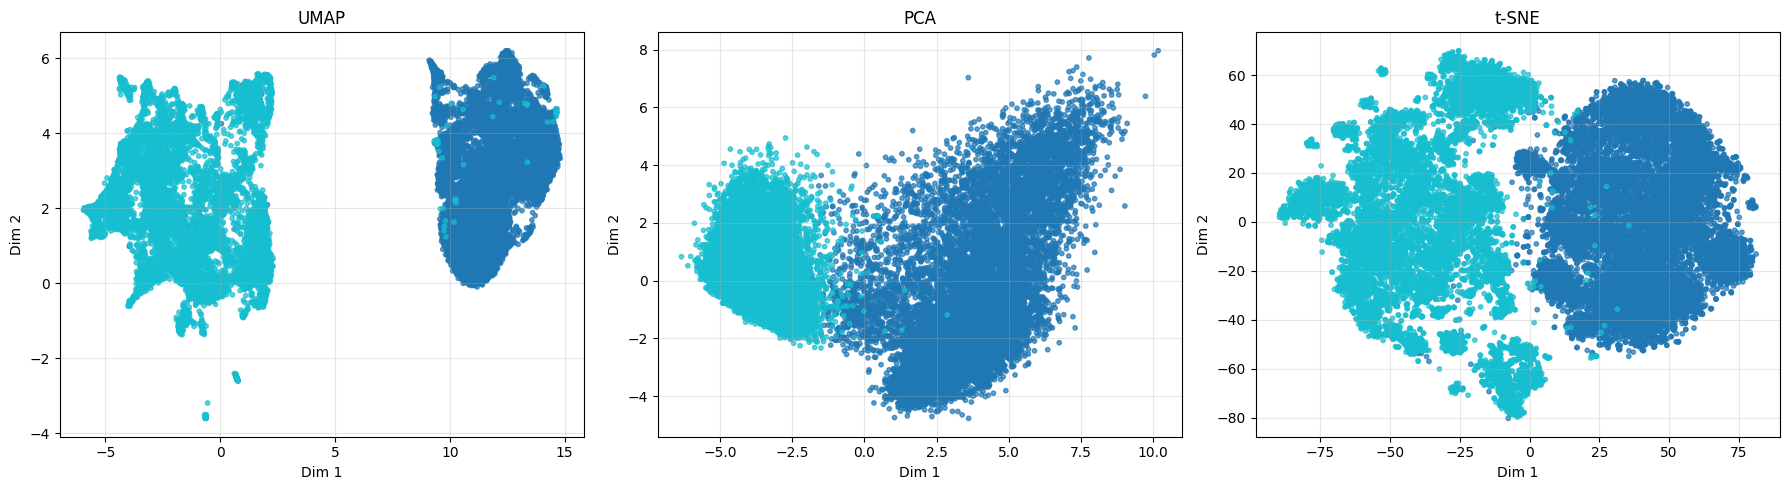

In [8]:
reducer_umap = umap.UMAP(n_components=2, random_state=67)
umap_2d = reducer_umap.fit_transform(train_features)

reducer_pca = PCA(n_components=2)  # 2 comps for fair comparison
pca_2d = reducer_pca.fit_transform(train_features)

reducer_tsne = TSNE(n_components=2, random_state=67)
tsne_2d = reducer_tsne.fit_transform(train_features)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(umap_2d[:,0], umap_2d[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
axes[0].set_title("UMAP")

axes[1].scatter(pca_2d[:,0], pca_2d[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
axes[1].set_title("PCA")

axes[2].scatter(tsne_2d[:,0], tsne_2d[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
axes[2].set_title("t-SNE")

for ax in axes:
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## 

## Clustering

Now to cluster our data. We will be using k-means and project in UMAP for visualisations as it provides very good results for this binary data.


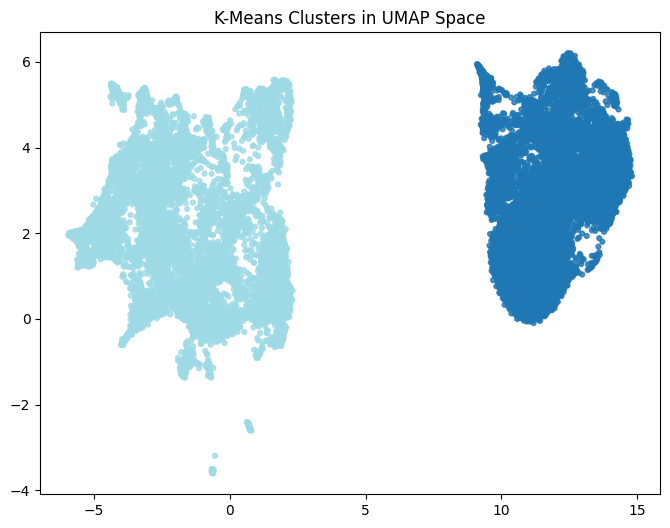

In [10]:
n_clusters = len(np.unique(train_labels))  # or choose the “true” number or experiment with k
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(umap_2d)  # features_2D from UMAP/PCA/t-SNE

# Visualize clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(umap_2d[:,0], umap_2d[:,1], c=cluster_labels, cmap='tab20', s=12, alpha=0.8)
plt.title('K-Means Clusters in UMAP Space')
plt.show()

Now we will get the measurable metrics of our clusters, but we can see visually these look very good.

In [14]:
db_score = davies_bouldin_score(umap_2d, cluster_labels)
sil_score = silhouette_score(umap_2d, cluster_labels)
print("Davies-Bouldin Index:", db_score)
print("Silhouette Score:", sil_score)

Davies-Bouldin Index: 0.3440170515519504
Silhouette Score: 0.7631113529205322


## Classifying

We are going to be trying a few classifiers now.
- logistic regression
- knn
- svm
- decision tree

In [9]:
# split data
x_train, x_test, y_train, y_test = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=67, stratify=train_labels
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=67)

# classifiers
models = {
    "LogReg": make_pipeline(StandardScaler(),
                            LogisticRegression(max_iter=2000, n_jobs=-1, random_state=67)),
    "KNN": make_pipeline(StandardScaler(),
                         KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
    "Linear SVM": make_pipeline(StandardScaler(),
                                SVC(kernel="linear", probability=True, random_state=67)),
    "Decision Tree": DecisionTreeClassifier(max_depth=20, random_state=67)
}

results = {}

# cross-validation data
for name, model in models.items():
    scores = []
    for train_idx, val_idx in cv.split(x_train, y_train):
        model.fit(x_train[train_idx], y_train[train_idx])
        pred = model.predict(x_train[val_idx])
        scores.append(accuracy_score(y_train[val_idx], pred))
    results[name] = {
        "model": model,
        "fold_scores": scores,
        "cv_mean": np.mean(scores),
        "cv_std": np.std(scores)
    }

# pick best model
best_name = max(results, key=lambda k: results[k]["cv_mean"])
best_model = results[best_name]["model"]

# train on full train set + evaluate
best_model.fit(x_train, y_train)
test_pred = best_model.predict(x_test)
test_acc = accuracy_score(y_test, test_pred)

print(f"Best model: {best_name}")
print(f"CV accuracy: {results[best_name]['cv_mean']:.4f} ± {results[best_name]['cv_std']:.4f}")
print(f"Test accuracy: {test_acc:.4f}\n")

print(classification_report(y_test, test_pred, target_names=dataset.classes))

# save
joblib.dump(best_model, "catsanddogs_best_model.joblib")

Best model: Linear SVM
CV accuracy: 0.9948 ± 0.0008
Test accuracy: 0.9956

              precision    recall  f1-score   support

         Cat       1.00      0.99      1.00      2498
         Dog       0.99      1.00      1.00      2494

    accuracy                           1.00      4992
   macro avg       1.00      1.00      1.00      4992
weighted avg       1.00      1.00      1.00      4992



['catsanddogs_best_model.joblib']

## Detailed Analysis - Confusion Matrices

Now we will analyse the confusion matrices of these classifiers.

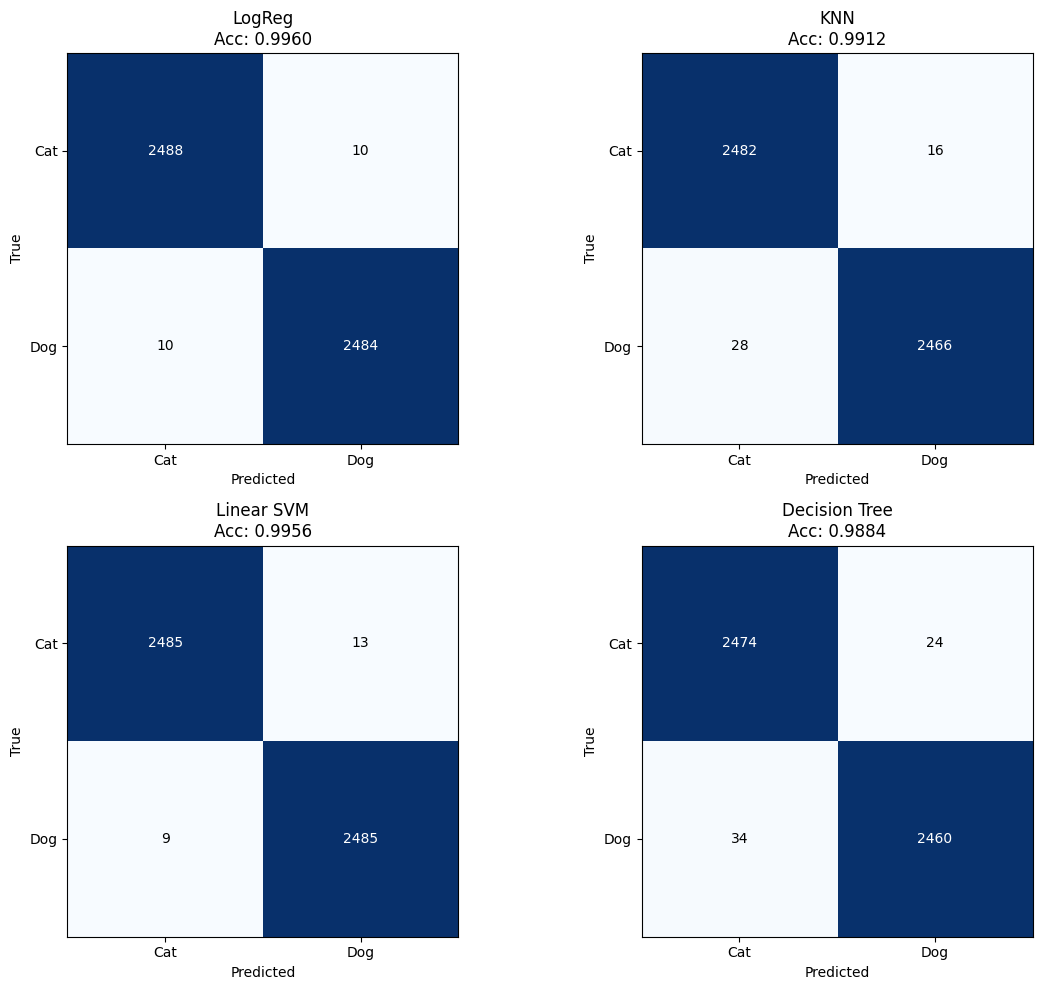


Best model: Linear SVM

Cat:  Precision=0.9964  Recall=0.9948  F1=0.9956
Dog:  Precision=0.9948  Recall=0.9964  F1=0.9956


In [26]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, res) in zip(axes, results.items()):

    model = res["model"]
    pred = model.predict(x_test)
    acc = accuracy_score(y_test, pred)
    cm = confusion_matrix(y_test, pred)
    
    ax.imshow(cm, cmap="Blues")
    ax.set_title(f"{name}\nAcc: {acc:.4f}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(len(dataset.classes)))
    ax.set_xticklabels(dataset.classes)
    ax.set_yticks(range(len(dataset.classes)))
    ax.set_yticklabels(dataset.classes)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black",
                    fontsize=10)

plt.tight_layout()
plt.show()

best_model = results[best_name]["model"]
best_pred = best_model.predict(x_test)

prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, best_pred, average=None
)

print(f"\nBest model: {best_name}\n")
for i, c in enumerate(dataset.classes):
    print(f"{c}:  Precision={prec[i]:.4f}  Recall={rec[i]:.4f}  F1={f1[i]:.4f}")


/tmp/ipykernel_257713/606087825.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(fold_scores, labels=clf_names, patch_artist=True)


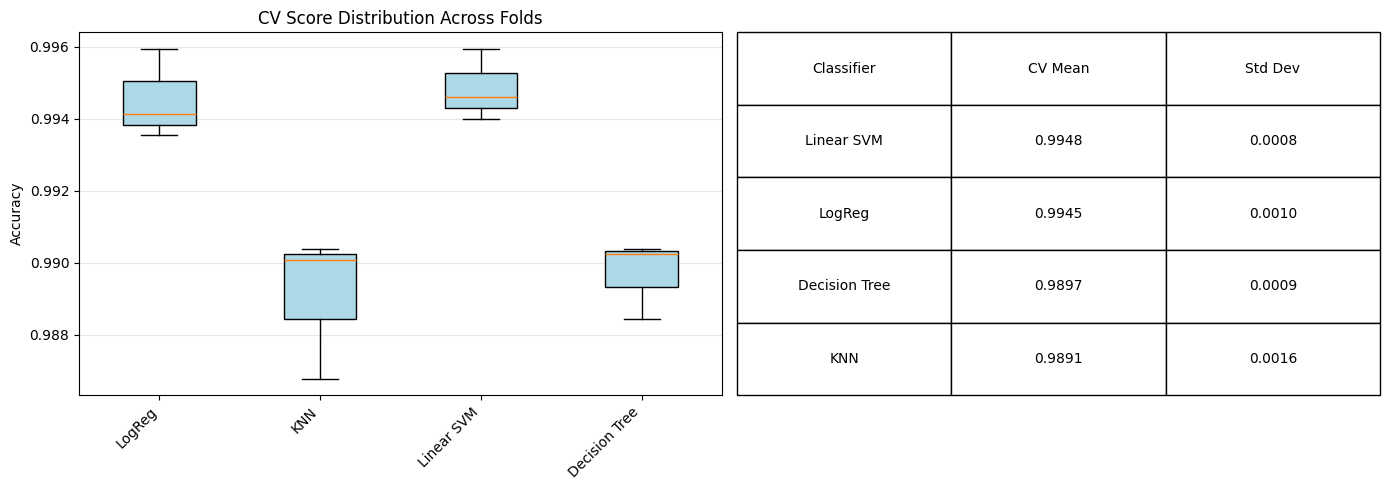

In [10]:
# CV Score distribution visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
clf_names = list(results.keys())
fold_scores = [results[name]['fold_scores'] for name in clf_names]
bp = ax1.boxplot(fold_scores, labels=clf_names, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax1.set_ylabel('Accuracy')
ax1.set_title('CV Score Distribution Across Folds')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Summary table
ax2.axis('off')
table_data = [[name, f"{results[name]['cv_mean']:.4f}", f"{results[name]['cv_std']:.4f}"] 
              for name in sorted(clf_names, key=lambda x: results[x]['cv_mean'], reverse=True)]
table = ax2.table(cellText=table_data,
                 colLabels=['Classifier', 'CV Mean', 'Std Dev'],
                 cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.tight_layout()
plt.show()

## Learning curves - overfitting

We will now be using learning curves to detect overfitting.


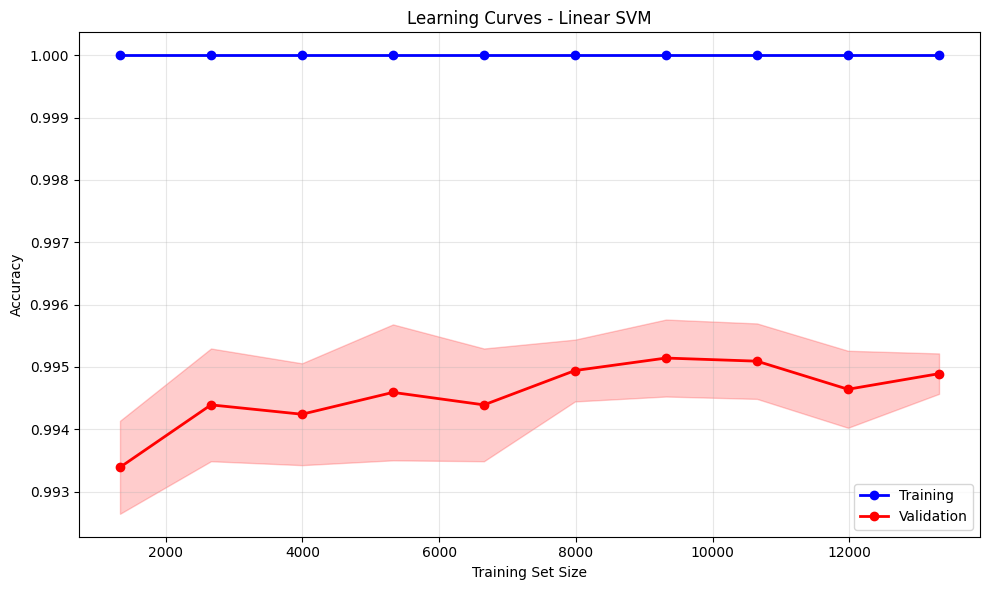


Learning Curve Analysis (Linear SVM):
Training Score: 1.0000 | Validation Score: 0.9949
Train-Val Gap: 0.0051


In [12]:
from sklearn.model_selection import learning_curve

# Get learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    results[best_name]['model'], x_train, y_train, 
    cv=3, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate means and stds
train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
val_mean, val_std = np.mean(val_scores, axis=1), np.std(val_scores, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training', linewidth=2)
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
ax.plot(train_sizes, val_mean, 'o-', color='red', label='Validation', linewidth=2)
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Accuracy')
ax.set_title(f'Learning Curves - {best_name}')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze
gap = train_mean[-1] - val_mean[-1]
print(f"\nLearning Curve Analysis ({best_name}):")
print(f"Training Score: {train_mean[-1]:.4f} | Validation Score: {val_mean[-1]:.4f}")
print(f"Train-Val Gap: {gap:.4f}")